In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt


load_dotenv()
ow_key = os.getenv('ow_key')

In [17]:
# Retreiving Plant Name (for Human readable data)
df_ip = pd.read_csv('data/inverter_plants.csv')

# Fix NaN plant_address values to 'Gazipur' for consistency
df_ip['plant_address'] = df_ip['plant_address'].fillna('Gazipur')

df = df_ip[['plant_id', 'plant_name', 'plant_address', 'plant_capacity']]

##############################################################

# Loading 5 minute inverter data
df_5m = pd.read_csv('data/inverter_five_minutes_generation_logs.csv')

df_5m['generation_date'] = pd.to_datetime(df_5m['generation_date'])
df_5m['date'] = df_5m['generation_date'].dt.date

# Adding plant name
df_5m = df_5m.merge(df, on='plant_id', how='left')

##############################################################

# Retreive various list
#df_5m['plant_name'].value_counts()
df_5m['plant_name'] = df_5m['plant_name'].fillna('Unknown Plant')
plant_list = df_5m['plant_name'].unique().tolist()

#df_5m['plant_address'].value_counts()
df_5m['plant_address'] = df_5m['plant_address'].fillna('Unknown Address')
adress_list = df_5m['plant_address'].unique().tolist()

##############################################################

# DATA CLEANING

df_5m.fillna(0, inplace=True)

# Remove " , " from the value in generation_amount :
df_5m['generation_amount'] = df_5m['generation_amount'].astype(str).str.replace(',', '')

# Transform "generation_amount" value to float
df_5m['generation_amount'] = df_5m['generation_amount'].astype(float)

# Unit transformation ??? (is it correct ?)
df_5m['generation_amount_kwh'] = df_5m['generation_amount'] / 1000

df_5m['generation_date'] = pd.to_datetime(df_5m['generation_date'])
df_5m['date'] = df_5m['generation_date'].dt.date

##############################################################

# SELECTING THE PLANT to observe
#df_5m = df_5m[df_5m['plant_name'] == 'HKL (GGI)']
df_HKL = df_5m[df_5m['plant_name'] == 'HKL (GGI)']

# GPS **HKL** coordinate
HKL_gps = 24.022350694140282, 90.29576719011767


PLANT: ACCL (GGI) → NO DATA FOUND


PLANT: ACML (GGI) → NO DATA FOUND


PLANT: CAL (GGI) → NO DATA FOUND


PLANT: HKL (GGI)
Period             : 2023-12-17  →  2025-10-22  (676 days)
Installed capacity : 269.28 kWp
Peak power recorded: 219.75 kW  →  81.6% of installed capacity
Expected 5-min points : 194,688
Available points      : 157,090  →  80.7% completeness
Missing points        : 37,598
Time with production  : 85,614 points  →  44.0% of theoretical time


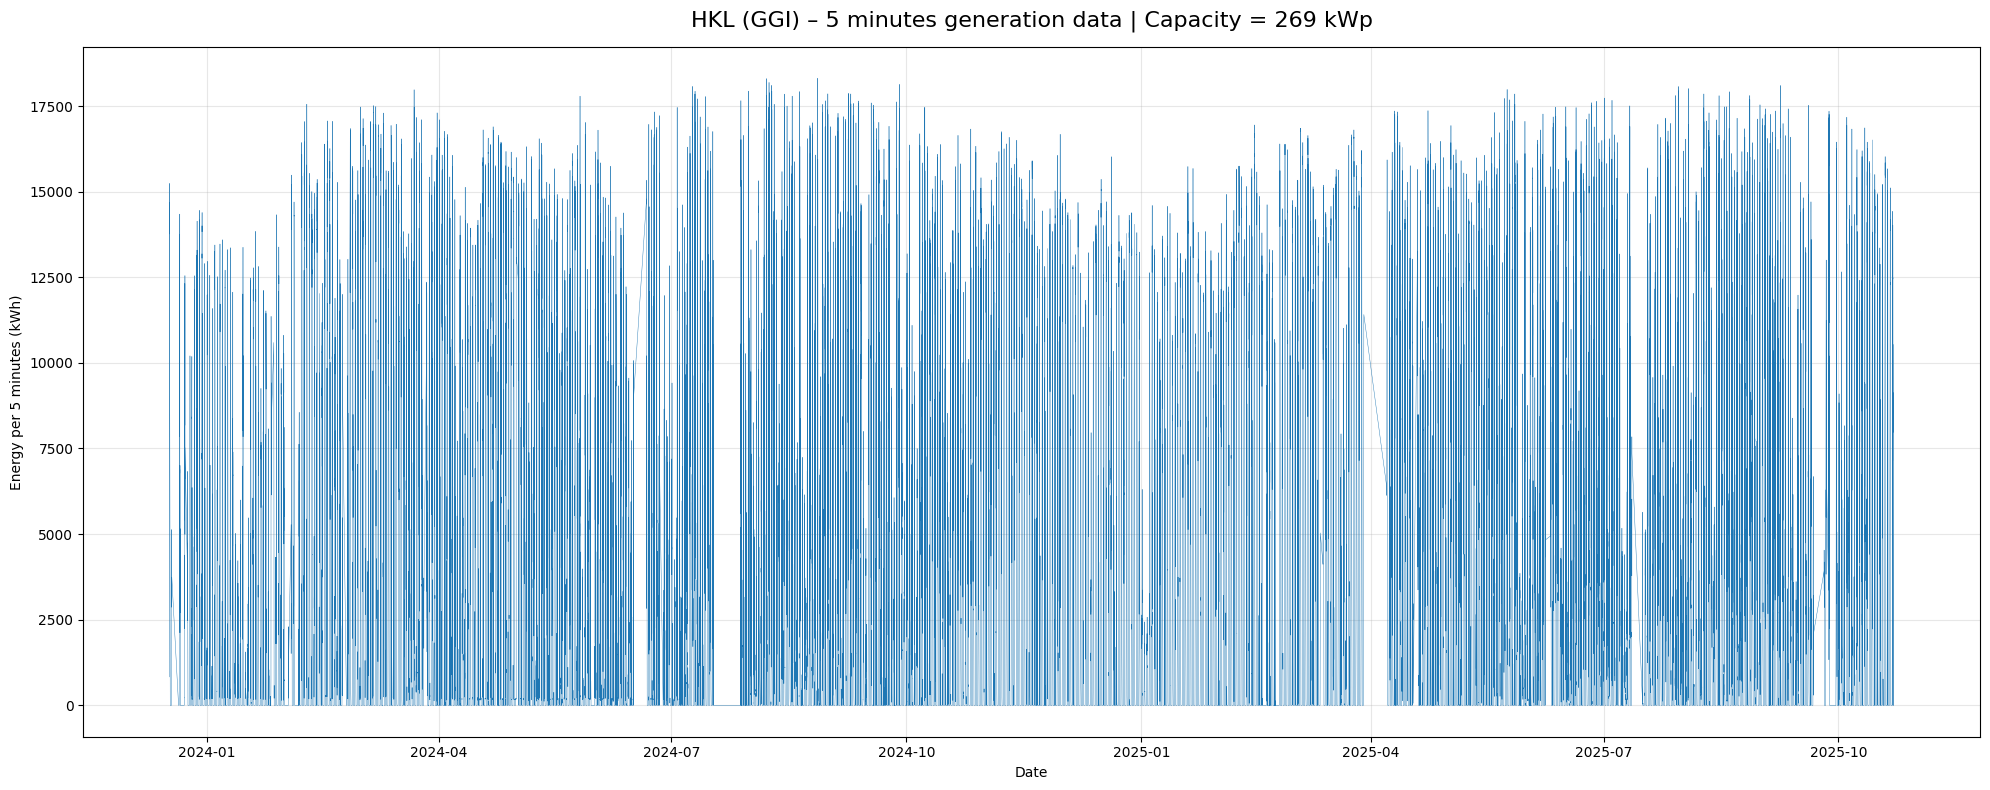


PLANT: NAL (GGI) → NO DATA FOUND


PLANT: KCL (SOLshare) → NO DATA FOUND


PLANT: Unilever Sales Depot Bogura → NO DATA FOUND


PLANT: Faruk Auto Garage Rajshahi → NO DATA FOUND


PLANT: Unknown Plant → NO DATA FOUND


PLANT: DGL (GGI) → NO DATA FOUND



In [4]:
# SHOW ONLY HKL GRAPHIC
df_5m = df_5m[df_5m['plant_name'] == 'HKL (GGI)']

for plant in plant_list:
    # Filter data for current plant
    df_temp = df_5m[df_5m['plant_name'] == plant].copy()

    # Skip if no data for this plant
    if df_temp.empty:
        print(f"\n{'='*60}")
        print(f"PLANT: {plant} → NO DATA FOUND")
        print(f"{'='*60}\n")
        continue

    df_temp = df_temp.sort_values('generation_date').reset_index(drop=True)

    # Date range
    start_date = df_temp['date'].min()
    end_date   = df_temp['date'].max()
    total_days = (end_date - start_date).days + 1

    # Plant capacity
    capacity_kw = df_temp['plant_capacity'].iloc[0]

    # Max instantaneous power: 5-min energy × 12 → kW
    max_5min_wh = df_temp['generation_amount'].max()
    max_power_kw = round(max_5min_wh * 12 / 1000, 2)

    # Expected number of 5-min data points over the period
    expected_points = total_days * 24 * 12
    available_points = len(df_temp)
    completeness = available_points / expected_points

    # Non-zero production points
    producing_points = df_temp[df_temp['generation_amount_kwh'] > 0]
    producing_ratio = len(producing_points) / expected_points

    print(f"\n{'='*70}")
    print(f"PLANT: {plant}")
    print(f"Period             : {start_date}  →  {end_date}  ({total_days} days)")

    if pd.notna(capacity_kw) and capacity_kw > 0:
        peak_ratio = round(max_power_kw / capacity_kw * 100, 1)
        print(f"Installed capacity : {capacity_kw:,.2f} kWp")
        print(f"Peak power recorded: {max_power_kw:,.2f} kW  →  {peak_ratio}% of installed capacity")
    else:
        print(f"Installed capacity : UNKNOWN or 0")
        print(f"Peak power recorded: {max_power_kw:,.2f} kW  →  ratio not available")

    print(f"Expected 5-min points : {expected_points:,}")
    print(f"Available points      : {available_points:,}  →  {completeness:.1%} completeness")
    print(f"Missing points        : {expected_points - available_points:,}")
    print(f"Time with production  : {len(producing_points):,} points  →  {producing_ratio:.1%} of theoretical time")

    # ------------------------------------------------------------------
    # Plot in English
    # ------------------------------------------------------------------
    plt.figure(figsize=(20, 8))
    plt.plot(df_temp['generation_date'], df_temp['generation_amount'], linewidth=0.3)

    title_capacity = f" | Capacity = {capacity_kw:,.0f} kWp" if (pd.notna(capacity_kw) and capacity_kw > 0) else " | Capacity unknown"
    plt.title(f"{plant} – 5 minutes generation data{title_capacity}",
              fontsize=16, pad=15)
    plt.xlabel("Date")
    plt.ylabel("Energy per 5 minutes (kWh)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [16]:
df_clean = df_5m.set_index('generation_date').copy()
full_index = pd.date_range(
    start=df_clean.index.min().ceil('5T'),
    end=df_clean.index.max().floor('5T'),
    freq='5T',
    name='generation_date'
)

df_regular = df_clean.reindex(full_index)
df_clean.info(), df_regular.info()

/var/folders/2c/jlpbrr154jg9cfp1pzbh8x5h0000gn/T/ipykernel_63138/3332732976.py:9: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df_regular = df_clean.reindex(full_index)


ValueError: cannot reindex on an axis with duplicate labels

In [6]:
df_HKL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157090 entries, 771 to 849536
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   plant_id               157090 non-null  int64              
 1   generation_date        157090 non-null  datetime64[ns, UTC]
 2   generation_amount      157090 non-null  float64            
 3   date                   157090 non-null  object             
 4   plant_name             157090 non-null  object             
 5   plant_address          157090 non-null  object             
 6   plant_capacity         157090 non-null  float64            
 7   generation_amount_kwh  157090 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(3)
memory usage: 10.8+ MB


In [7]:
# # Resample for hourly data (to match meteo data)
# df_HKL = df_HKL.set_index('generation_date').resample('H')['generation_amount'].sum()

df_HKL = (
    df_HKL
    .set_index('generation_date')
    .resample('1H')
    .agg({
        'generation_amount_kwh': 'sum',    # énergie totale par heure
        'plant_capacity': 'first',         # constant
        'plant_name': 'first'
    })
    .rename(columns={'generation_amount_kwh': 'energy_kwh'})
    .reset_index()
)

print(f"→ df_HKL : {len(df_HKL)} lignes horaires")

→ df_HKL : 16206 lignes horaires


In [8]:
# Retreive Historical Meteo Data. (data was bought from https://openweathermap.org/)
df_gazi_weather = pd.read_csv('open_data/gazipur_weather.csv')
df_gazi_weather = df_gazi_weather.fillna(0)

df_gazi_weather = df_gazi_weather[['dt_iso',
                                   'temp',
                                   'visibility',
                                   'rain_1h',
                                   'clouds_all']]


df_gazi_weather = df_gazi_weather.rename(columns={'dt_iso': 'generation_date'})


# Clean the 'generation_date' column by removing ' UTC' (assuming this pattern is consistent)
df_gazi_weather['generation_date'] = df_gazi_weather['generation_date'].str.replace(' UTC', '')


# TODO > RETREIVE DAILY METEO DATA
# Convert to datetime with UTC timezone
df_gazi_weather['generation_date'] = pd.to_datetime(df_gazi_weather['generation_date'], utc=True)

In [9]:

df_HKL = df_gazi_weather.merge(df_HKL, on='generation_date', how='right')

df_HKL['generation_date'] = df_HKL['generation_date'].dt.tz_convert('Asia/Dhaka')

df_HKL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16493 entries, 0 to 16492
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype                     
---  ------           --------------  -----                     
 0   generation_date  16493 non-null  datetime64[ns, Asia/Dhaka]
 1   temp             16493 non-null  float64                   
 2   visibility       16493 non-null  float64                   
 3   rain_1h          16493 non-null  float64                   
 4   clouds_all       16493 non-null  int64                     
 5   energy_kwh       16493 non-null  float64                   
 6   plant_capacity   13804 non-null  float64                   
 7   plant_name       13804 non-null  object                    
dtypes: datetime64[ns, Asia/Dhaka](1), float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [10]:
import pvlib
from pvlib.location import Location

location = Location(
    latitude = HKL_gps[0],
    longitude = HKL_gps[1],
    tz='Asia/Dhaka')

times = df_HKL['generation_date']

# Solar Position
solpos = location.get_solarposition(times)

# Date Range
full_range = pd.date_range(start=df_HKL['generation_date'].min(),
                           end=df_HKL['generation_date'].max(),
                           freq='H',
                           tz='Asia/Dhaka')

# Clearsky SOLAR IRRADIANCE
clearsky = location.get_clearsky(full_range)
clearsky


# Reset index and name the index for merging
solpos_reset = solpos.reset_index().rename(columns={'index': 'generation_date'})
clearsky_reset = clearsky.reset_index().rename(columns={'index': 'generation_date'})

# Merge solpos (by generation_date) onto df_HKL
df_HKL = df_HKL.merge(solpos_reset, on='generation_date', how='left')

# Merge clearsky (by generation_date) onto df_HKL
df_HKL = df_HKL.merge(clearsky_reset, on='generation_date', how='left')

df_HKL.info()

# # Remove Night Time
# df_HKL['is_daytime'] = df_HKL['apparent_elevation'] > 0
# df_HKL = df_HKL['is_daytime'] == True
# df_HKL.column()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17067 entries, 0 to 17066
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype                     
---  ------              --------------  -----                     
 0   generation_date     17067 non-null  datetime64[ns, Asia/Dhaka]
 1   temp                17067 non-null  float64                   
 2   visibility          17067 non-null  float64                   
 3   rain_1h             17067 non-null  float64                   
 4   clouds_all          17067 non-null  int64                     
 5   energy_kwh          17067 non-null  float64                   
 6   plant_capacity      14304 non-null  float64                   
 7   plant_name          14304 non-null  object                    
 8   apparent_zenith     17067 non-null  float64                   
 9   zenith              17067 non-null  float64                   
 10  apparent_elevation  17067 non-null  float64                   
 11  el

In [11]:
df_HKL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17067 entries, 0 to 17066
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype                     
---  ------              --------------  -----                     
 0   generation_date     17067 non-null  datetime64[ns, Asia/Dhaka]
 1   temp                17067 non-null  float64                   
 2   visibility          17067 non-null  float64                   
 3   rain_1h             17067 non-null  float64                   
 4   clouds_all          17067 non-null  int64                     
 5   energy_kwh          17067 non-null  float64                   
 6   plant_capacity      14304 non-null  float64                   
 7   plant_name          14304 non-null  object                    
 8   apparent_zenith     17067 non-null  float64                   
 9   zenith              17067 non-null  float64                   
 10  apparent_elevation  17067 non-null  float64                   
 11  el

In [12]:
print("Nb timestamps uniques dans df_HKL :", df_HKL['generation_date'].nunique())
# → probablement 16 493

print("Nb timestamps dans full_range (clearsky) :", len(full_range))
# → probablement 17 067 ou 17 068 → bingo !

Nb timestamps uniques dans df_HKL : 16206
Nb timestamps dans full_range (clearsky) : 16206


In [13]:
import pvlib
from pvlib.location import Location

# Coordinates of the plant (to be retrieved or inferred via plant_address)
location = Location(latitude=24.022350694140282, longitude=90.29576719011767, tz='Asia/Dhaka', altitude=50)

# Use generation_date directly, as it is already tz-aware (do not call tz_localize)
times = df_5m['generation_date']

# Ensure times is sorted and has no NaT
times = times.dropna().sort_values()

# Reindex clearsky and solpos to match df_5m's index
solpos = location.get_solarposition(times)
# Ensure times is a DatetimeIndex with a regular frequency for clearsky calculation
if isinstance(times, pd.Series):
    times_index = pd.DatetimeIndex(times)
else:
    times_index = times

# Attempt to infer freq; if not possible, default to 5min
if times_index.freq is None:
    inferred_freq = pd.infer_freq(times_index)
    if inferred_freq is not None:
        freq = inferred_freq
    else:
        freq = '5min'
    # Construct a new index with consistent frequency covering the same range
    full_range = pd.date_range(start=times_index.min(), end=times_index.max(), freq=freq, tz=times_index.tz)
    clearsky = location.get_clearsky(full_range)
    clearsky = clearsky.reindex(times_index, method='nearest')
else:
    clearsky = location.get_clearsky(times_index)

# We must align the result exactly to the index of df_5m for correct assignment (in case of missing rows/Nat)
df_5m = df_5m.copy()
df_5m['ghi_clear'] = clearsky['ghi'].reindex(df_5m.index, fill_value=0).to_numpy()

# Only fill expected_power for HKL (GGI). Others should be NaN.
plant_capacity = df_5m.loc[df_5m['plant_name'] == 'HKL (GGI)', 'plant_capacity'].iloc[0]
PR_typique = 0.82  # Typical performance ratio

df_5m['expected_power'] = float('nan')
mask_hkl = df_5m['plant_name'] == 'HKL (GGI)'
df_5m.loc[mask_hkl, 'expected_power'] = (
    df_5m.loc[mask_hkl, 'ghi_clear'] * plant_capacity * PR_typique
)

/var/folders/2c/jlpbrr154jg9cfp1pzbh8x5h0000gn/T/ipykernel_63138/737027243.py:37: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df_5m['ghi_clear'] = clearsky['ghi'].reindex(df_5m.index, fill_value=0).to_numpy()


ValueError: cannot reindex on an axis with duplicate labels